![Image](https://miro.medium.com/max/1400/1*AMYKSt713dygHFRall7sZg.jpeg)

# 概述

Matrix factorization Recommendation  
采用矩阵分解的做法（矩阵分解是隐语义模型（LFM）的重要分支）   
主要三种：特征值分解（只能作用于方阵），奇异值分解（它虽然可以用于非方阵，但对于特别稀疏的评分矩阵效果很差），所以本文打算借鉴Funk-SVD的思想分解为两个较小的矩阵(**不是传统线代上的SVD**)，着重考虑这种存在大量缺失值的矩阵。

# 主要思想

<font color='red'>参考2006年Netflix Prize竞赛中使用 SGD for MF 发表的主要突破</font>

### 首先我们将假设用户对电影的评分由有关该电影各个**特征features**的偏好的总和组成

如果将其限制为40个features的话，就表示每部电影仅由四十个值描述，表示该电影在多大程度上体现了每个feature，相应地，每个用户都由四十个值描述，说明他们更喜欢每个feature的程度。为了将这些组合成一个评级，我们只需将每个用户偏好乘以相应的电影方面，然后将这四十个倾向相加，以最终得出用户对该电影的喜爱程度的看法。  
ratingsMatrix[user][movie] = sum (userFeature[f][user] * movieFeature[f][movie]) for f from 1 to 40

### **在矩阵方面**，原始矩阵已被分解为两个非常长方形的矩阵，这些矩阵可以最小化产生的近似误差 - 特别是均方误差

在开始使用SVD之前，通过记下每部电影的平均评分，以及每个用户的用户评分与电影的平均评分之间的平均偏移量，可以获得良好的开端。即，该<u>baseline</u>模型的预测方法是（c语言）：  
static inline  
real predictRating_Baseline(int movie, int user) {  
&nbsp;return averageRating[movie] + averageOffset[user];  
}

### 定义**损失函数**学习两个矩阵

**改进(adding bias)**

**偏移量Offset**表示用户评分相对于平均值的偏移量，不受物品属性的影响。比如对于乐观用户会偏高，消极用户会偏低。

**注意真正的平均值很可能比稀疏观察到的平均值更接近先验平均值，对于平均评分和偏移量都是如此。**

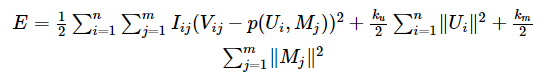

In [3]:
from IPython.display import Image
Image("D:/picture/lossFuction.png")

这里的评价指标metric采用的是RMSE。

其中p(Ui,Mj)代表用户i对电影j的预测，最常用的预测函数p就是点乘，即 p(Ui,Mj)=UTiMj。

<font color='purple'>上式中的 I ∈ {0,1}n×m，为一个指示器，指示相应位置是否有评分，有评分为1，没有就为0。</font>

等式右边最后两项是**正则化项(regularizer)**，防止过拟合，简单来说，为了同时满足特征数量的不至于过多，即0范数（向量中非零元素的个数），对代价函数来说，就是加入对模型“长相”的惩罚。

<font color='purple'>Funk-svd考虑要最小化的实际损失函数包括一个通用偏差项和用户和项目的两个偏差，  
其中u为所有电影items的平均评分，bi和bu分别表示item i的平均得分减去u和user u的平均评分减去u。</font>同时添加正则项。

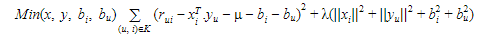

### **梯度下降**最小化损失函数

设置学习率，进行梯度下降

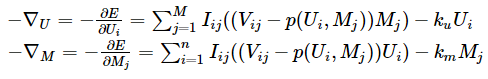

In [4]:
Image("D:/picture/SGD.png")

# 实验

### 数据预处理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.sparse as sparse

%matplotlib inline

!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
    
!cd ml-100k/

In [59]:
df = pd.read_csv('D:/documents/ml-latest-small/ratings.csv')
ratings = df
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [60]:
df.userId.nunique(), df.movieId.nunique()

(610, 9724)

可以看到我们有610个独特的用户和9724个电影

In [61]:
ratings3 = df[["userId", "movieId", "rating"]]
data = df.groupby("userId", as_index=False).agg({"movieId": 'count'})
data.head()

,userId,movieId
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


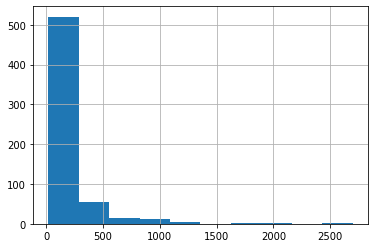

In [62]:
data.movieId.hist();

In [63]:
data.movieId.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: movieId, dtype: float64

可以看到用户平均会评分165部电影，且至少给20部电影评分。

### 创建矩阵，在未评分位置先填为0，则需要用使用稀疏矩阵来节省内存

In [65]:
from pandas.api.types import CategoricalDtype
# 使用scipy库
from scipy import sparse
import scipy

users = list(np.sort(ratings.userId.unique())) # 独特用户
movies = list(ratings.movieId.unique()) # 独特电影
rating = list(ratings.rating) # 所有评分

rows = ratings.userId.astype(CategoricalDtype(categories=users)).cat.codes
# Get the associated row indices
cols = ratings.movieId.astype(CategoricalDtype(categories=movies)).cat.codes
# Get the associated column indices
user_item = sparse.csr_matrix((rating, (rows, cols)), shape=(len(users), len(movies)))

In [12]:
matrix_size = user_item.shape[0]*user_item.shape[1] # 总的
num_purchases = len(user_item.nonzero()[0]) # 非零的
sparsity = 100*(1 - (1.0*num_purchases/matrix_size))
sparsity

98.30003169443864

In [13]:
user_item

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

用户项目矩阵有610个唯一用户和9724个唯一电影，且稀疏度为98.3%

## 使用surprise库实现电影推荐系统

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from surprise import SVD, KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate

In [5]:
data = Dataset.load_builtin('ml-100k', prompt = False)

Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to C:\Users\argon/.surprise_data/ml-100k


一种新的类型 **surprise.dataset**，这已经不是pandas的dataframe，这样做的目的只是方便我们更好使用surprise的各种API

In [23]:
ratings_data = pd.read_csv("D:/documents/ml-latest-small/ratings.csv")
movies_data = pd.read_csv("D:/documents/ml-latest-small/movies.csv")

In [51]:
ratings_data

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [32]:
movies_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


### 文档参数解释

Surprise文档  
Root Mean Squared Error (RMSE)
Mean Absolute Error (MAE)

训练时可用交替最小二乘ALS(Alternating Least Squares)、随机梯度下降SGD(Stochastic Gradient Descent)，以下采用SGD算法加速梯度下降  
n_factor是影响因素即特征的数量，默认100  
n_epochs是SGD过程的迭代次数，默认20  

* algo(AlgoBase)：即所用算法
* data(Dataset)：即数据集
* measures(list of string)：要计算的性能指标；默认为['RMSE', 'MAE']
* cv (cross-validation迭代器, int or None)：将数据分为几堆来进行交叉循环验证，默认为5
* verbose(int)：True则打印详细内容

In [6]:
# 用著名的SVD算法
algo = SVD(n_epochs=10)

In [7]:
# 分5部分进行交叉验证结果
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9352  0.9392  0.9313  0.9396  0.9415  0.9374  0.0036  
MAE (testset)     0.7369  0.7409  0.7342  0.7414  0.7415  0.7390  0.0029  
Fit time          3.53    3.61    3.56    3.52    3.64    3.57    0.05    
Test time         0.11    0.16    0.10    0.10    0.10    0.11    0.03    


### SVD++实验，时间较长，效果稍好一些

In [9]:
from surprise import SVDpp
from surprise import Dataset
from surprise.model_selection import cross_validate

In [10]:
algo = SVDpp()

In [11]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9177  0.9191  0.9215  0.9286  0.9171  0.9208  0.0042  
MAE (testset)     0.7189  0.7217  0.7203  0.7282  0.7202  0.7219  0.0033  
Fit time          138.67  137.72  139.49  144.65  143.62  140.83  2.78    
Test time         2.43    2.44    2.45    2.56    2.62    2.50    0.08    


### 超参调优

GridSearchCV可以来帮助来调整参数

In [12]:
from surprise.model_selection import GridSearchCV

In [13]:
# 找到更合适的参数
param_grid = {
  'n_factors': [20, 50, 100],
  'n_epochs': [5, 10, 20]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9271950331555333
{'n_factors': 50, 'n_epochs': 20}


使用这些参数重新训练模型

In [14]:
from surprise.model_selection import train_test_split
 
# 应用最好的超参
best_factor = gs.best_params['rmse']['n_factors']
best_epoch = gs.best_params['rmse']['n_epochs']
 
# sample random trainset and testset
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(data, test_size=.20)
 
# We'll use the famous SVD algorithm.
svd = SVD(n_factors=best_factor, n_epochs=best_epoch)
 
# Train the algorithm on the trainset
svd.fit(trainset)

### 推荐电影

首先，我们必须找到特定用户未看过的电影列表。
之后，我们可以使用模型预测缺失位置。
最后，我们可以通过对电影进行排名来获得前n名电影的推荐。

In [47]:
def generate_recommendation(model, user_id, ratings_df, movies_df, n_items):
    list_id = []
    
    # 得到所有用户ID列表
    movie_ids = ratings_df["movieId"].unique()
 
    # 得到用户评分的电影列表
    movie_ids_user = ratings_df.loc[ratings_df["userId"] == user_id, "movieId"]
    # 获取用户未观看的所有电影 IDS 的列表
    movie_ids_to_pred = np.setdiff1d(movie_ids, movie_ids_user)
 
    # 对所有的评分应用为4 (只是为了符合Surprise dataset规范)
    test_set = [[user_id, movie_id, 4] for movie_id in movie_ids_to_pred]
 
    # 预测评分并推荐
    predictions = model.test(test_set)
    pred_ratings = np.array([pred.est for pred in predictions])
    print("Top {0} item recommendations for user {1}:".format(n_items, user_id))
    # 根据评分对top电影评分
    index_max = (-pred_ratings).argsort()[:n_items]
    for i in index_max:
        movie_id = movie_ids_to_pred[i]
        print(movies_df[movies_df["movieId"]==movie_id]["title"].values[0], pred_ratings[i])
        list_id.append(movie_id)  
    return list_id

# 做推荐的用户
userID = 23
# 推荐top-n电影
n_items = 10
# 生成推荐
top10 = []
top10 = generate_recommendation(svd,userID,ratings_data,movies_data,n_items)

Top 10 item recommendations for user 23:
Toy Story (1995) 3.5299125
Tell No One (Ne le dis à personne) (2006) 3.5299125
Superbad (2007) 3.5299125
Brice Man, The (Brice de Nice) (2005) 3.5299125
Rush Hour 3 (2007) 3.5299125
Last Legion, The (2007) 3.5299125
Balls of Fury (2007) 3.5299125
China Blue (2005) 3.5299125
Sydney White (2007) 3.5299125
Rocket Science (2007) 3.5299125


### 显示海报

In [49]:
top10

[1, 54372, 54503, 54617, 54648, 54686, 54732, 54354, 54734, 54745]

In [50]:
api_key = '54341d147efe7b33dece6eb76f0b8985'

from IPython.display import Image
from IPython.display import display

movie_id = 54686 # one in top10，暂时只显示（最后）一张

url = "https://api.themoviedb.org/3/movie/{}?api_key=54341d147efe7b33dece6eb76f0b8985&language=en-US".format(movie_id)
data = requests.get(url)
data = data.json()
poster_path = data['poster_path']
full_path = "https://image.tmdb.org/t/p/original" + poster_path
Image(url=full_path, width=100, height=100)

## SVD方法从0实现

* create_utility_matrix接受array，返回矩阵（n x m），n为用户，m为电影
* svd 基于numpy实现svd分解，只分析最大的k个特征，其中将nan或不可用的条目同样置为0

In [13]:
# 使用scipy库
from scipy import sparse
import scipy
from scipy.linalg import sqrtm

In [14]:
# 矩阵的一种创建方式
def create_utility_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
    """
        :param data:      Array-like, 2D, nx3
        :param formatizer:pass the formatizer
        :return:          utility matrix (n x m), n=users, m=items
    """
        
    itemField = formatizer['item']
    userField = formatizer['user']
    valueField = formatizer['value']
    userList = data.iloc[:,userField].tolist()
    itemList = data.iloc[:,itemField].tolist()
    valueList = data.iloc[:,valueField].tolist()
    users = list(set(data.iloc[:,userField]))
    items = list(set(data.iloc[:,itemField]))
    users_index = {users[i]: i for i in range(len(users))}
    pd_dict = {item: [np.nan for i in range(len(users))] for item in items}
    for i in range(0,len(data)):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]
    pd_dict[item][users_index[user]] = value
    X = pd.DataFrame(pd_dict)
    X.index = users
        
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    # users_index 提供了 user_id 到用户索引的映射
    # items_index 提供同样的到电影
    return X, users_index, items_index

In [15]:
# svd的实现
def svd(train, k):
    utilMat = np.array(train)
    # nan或不可用的条目被屏蔽
    mask = np.isnan(utilMat)
    masked_arr = np.ma.masked_array(utilMat, mask)
    item_means = np.mean(masked_arr, axis=0)
    # nan 条目将替换为每个项目的平均评分
    utilMat = masked_arr.filled(item_means)
    x = np.tile(item_means, (utilMat.shape[0],1))
    # 移除平均的电影，现在nan的几乎就都是0了
    utilMat = utilMat - x
    # 使用numpy.linalg的svd，U and V are user and item features
    U, s, V=np.linalg.svd(utilMat, full_matrices=False)
    s=np.diag(s)
    # 只取最具大的k个特征
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]
    s_root=sqrtm(s)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    UsV = UsV + x
    print("svd done")
    return UsV

In [16]:
# 定义一下rmse损失函数
def rmse(true, pred):
    x = true - pred
    return sum([xi*xi for xi in x])/len(x)

## PyTorch训练网络

In [ ]:
import os

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class MFDataset(Dataset):
    def __init__(self, u_id, i_id, rating):
        self.u_id = u_id
        self.i_id = i_id
        self.rating = rating

    def __getitem__(self, index):
        return self.u_id[index], self.i_id[index], self.rating[index]

    def __len__(self):
        return len(self.rating)


class MF(nn.Module):
    def __init__(self, num_users, num_items, mean, embedding_size=100):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, embedding_size)  # 隐向量
        self.user_bias = nn.Embedding(num_users, 1)  # 用户偏置
        self.item_emb = nn.Embedding(num_items, embedding_size)  # 隐向量
        self.item_bias = nn.Embedding(num_items, 1)  # 物品偏置

        # 参数初始化
        self.user_emb.weight.data.uniform_(0, 0.005)  # 0-0.05之间均匀分布
        self.user_bias.weight.data.uniform_(-0.01, 0.01)
        self.item_emb.weight.data.uniform_(0, 0.005)
        self.item_bias.weight.data.uniform_(-0.01, 0.01)

        # 全局偏置
        # 将不可训练的tensor转换成可训练的类型parameter，并绑定到module里，net.parameter()中就有了这个参数
        self.mean = nn.Parameter(torch.FloatTensor([mean]), False)

    def forward(self, u_id, i_id):
        U = self.user_emb(u_id)
        b_u = self.user_bias(u_id).squeeze()
        I = self.item_emb(i_id)
        b_i = self.item_bias(i_id).squeeze()
        return (U * I).sum(1) + b_u + b_i + self.mean  # 返回预测评分


def train(model, x_train, y_train, loss_func):
    train_ls = []  # 返回训练误差
    train_dataset = MFDataset(x_train[:, 0], x_train[:, 1], y_train)
    # DataLoader将一个batch_size封装成一个tensor，方便迭代
    train_iter = DataLoader(train_dataset, batch_size=1024)

    # weight_decay是正则化系数
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)
    model = model.float()
    for epoch in range(50):
        model.train()  # 如果模型中有Batch Normalization或Dropout层，需要在训练时添加model.train()，使起作用
        total_loss, total_len = 0.0, 0
        for x_u, x_i, y in train_iter:
            y_pred = model(x_u, x_i)
            l = loss_func(y_pred, y).sum()
            optimizer.zero_grad()  # 清空这一批的梯度
            l.backward()  # 回传
            optimizer.step()  # 参数更新

            total_loss += l.item()
            total_len += len(y)
        train_ls.append(total_loss / total_len)
    return train_ls


if __name__ == '__main__':
    pd.set_option('display.max_rows', 1000, 'display.max_columns', None,
                  'display.float_format', lambda x: "%.2f" % x)
    # path = r'D:\documents\ml-latest-small'
    # df = readRatings(path)

    df = pd.read_csv('D:/documents/ml-latest-small/ratings.csv')

    x, y = df.iloc[:, :2], df.iloc[:, 2]
    x = torch.tensor(x.values, dtype=torch.int64)
    y = torch.tensor(y.values, dtype=torch.float32)

    x_train, x_test, y_train, y_test = train_test_split(x.numpy(), y.numpy(), test_size=0.3, random_state=1)

    mean_rating = df.iloc[:, 2].mean()
    # 虽然数据集的UserID是从1开始的，但这里还是需要+1，因为nn.Embedding是从索引0开始，而model(x_u, x_i)传的是真实的ID
    num_users, num_items = df['userId'].max() + 1, df['movieId'].max() + 1

    model = MF(num_users, num_items, mean_rating)
    # 已经训练好了保存模型，训练时间较长
    # loss = nn.MSELoss(reduction='sum')
    #
    # train_ls = train(model, x_train, y_train, loss)
    # print(train_ls)

    # PATH = 'D:/python_projects/Matrix'
    # torch.save(model.state_dict(), os.path.join(PATH, "mf.pth"))

    model.load_state_dict(torch.load('D:/python_projects/Matrix/mf.pth'))

    u_tensor = torch.tensor([23], dtype=torch.int64)
    i_tensor = torch.tensor([54686], dtype=torch.int64)
    prediction = model(u_tensor, i_tensor)

在PyCharm上基于PyTorch的虚拟环境训练结果如下：

loss值：  
[1.0859073494888698, 1.0793489743015403, 1.0707012996091259, 1.0594407555772738, 1.0457588733538796, 1.0301769373597103, 1.0133403015244806, 0.9958982489944526, 0.9784321317424802, 0.961414194211766, 0.9451898416885448, 0.9299781444247184, 0.9158858890834742, 0.9029298137468345, 0.891062052705736, 0.8801944571344611, 0.8702191257659205, 0.8610233962708967, 0.8524997417992823, 0.8445512817408753, 0.8370939927743921, 0.8300569068847622, 0.8233810936061132, 0.8170180041129489, 0.8109277426761617, 0.8050774643658798, 0.7994399309952097, 0.7939924181339432, 0.7887157890102027, 0.7835937984234433, 0.7786126024570885, 0.7737602768382092, 0.7690265514732901, 0.7644025173134563, 0.7598804568724211, 0.7554536660973914, 0.7511162796987896, 0.7468632140797664, 0.7426899978541497, 0.7385927355288615, 0.7345680218981879, 0.7306128884321098, 0.7267247410175897, 0.7229013046174936, 0.7191406353764521, 0.7154410004269565, 0.7118009038304881, 0.708219025183511, 0.7046942213468801, 0.7012254659165368]

可见可以达到很接近0.7的误差

**预测某个用户对某部电影评分**，如预测用户ID23对电影ID54686的评分为：3.4884

# 电影推荐系统现状发展

传统的推荐系统除了协同过滤的**SVD(低秩分解，不是传统线代里的SVD)**，还有基于用户UserCF和基于物品ItemCF的方法，例如可以用k近邻KNN并用余弦计算相似度。以及**神经网络**方法等。  
* 考虑**truncated SVD**降维，只采用最大的k奇异值，它是可以处理稀疏矩阵以生成特征矩阵，同样可以降维，与PCA对比，PCA将对整个矩阵进行操作，以输出协方差矩阵。  
* 另外考虑从概率角度推出的**PMF**，它使用最大后验近似来学习模型(贝叶斯派那个)，低秩矩阵分解试图最小化由两个低秩矩阵的乘法近似的矩阵的 L2 损失，PMF中选择的Gussian方差与SVD损失中的加权参数（重量衰减的超参数）之间存在关系。  

按照推荐系统应用场景可以大致划分为：CTR预估、TopN推荐、对话式推荐、序列推荐等。同时，GNN、强化学习、多任务学习、迁移学习、AutoML、元学习在推荐系统的落地应用也成为当下的主要研究点。此届会议有很大一部分来自工业界的论文，包括Google、Microsoft、Criteo、Spotify以及国内大厂阿里、百度、字节、华为、滴滴等。